In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from ast import literal_eval
import pingouin as pg
from statsmodels.stats.weightstats import ztest

import pingouin as pg
%matplotlib inline

In [2]:
# Читаю данные
users_test = pd.read_csv('data/Проект_3_users_test.csv', sep=';')
users_control_1 = pd.read_csv('data/Проект_3_users_control_1.csv', sep=';')
users_control_2 = pd.read_csv('data/Проект_3_users_control_2.csv', sep=';')
transactions_test = pd.read_csv('data/Проект_3_transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv('data/Проект_3_transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv('data/Проект_3_transactions_control_2.csv', sep=';')

# описательная статистика

In [3]:
print(f"В датафрейме users_test {users_test.shape[0]} строк")
print(f"В датафрейме users_control_1 {users_control_1.shape[0]} строк")
print(f"В датафрейме users_control_2 {users_control_2.shape[0]} строк")
print(f"В датафрейме transactions_test {transactions_test.shape[0]} строк")
print(f"В датафрейме transactions_control_1 {transactions_control_1.shape[0]} строк")
print(f"В датафрейме transactions_control_2 {transactions_control_2.shape[0]} строк")

В датафрейме users_test 4308 строк
В датафрейме users_control_1 4340 строк
В датафрейме users_control_2 4264 строк
В датафрейме transactions_test 273 строк
В датафрейме transactions_control_1 1007 строк
В датафрейме transactions_control_2 328 строк


In [4]:
users_test.isnull().sum()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
users_control_1.isnull().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [6]:
users_control_2.isnull().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

В таблицах с юзерами не наблюдаю аномалий. Много пропусков в coins, т.к не у всех пользователей есть внутренняя валюта, пропуски в visit_days, т.к не все пользователи хоть раз использовали приложение, пропуски в was/is premium, т.к не все покупают подписку.

In [7]:
transactions_test.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [8]:
transactions_control_1.isnull().sum()

uid             630
country         630
joined_at         0
paid_at           0
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [9]:
transactions_control_2.isnull().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В таблице transactions_control_1 явно что-то сломалось, дропну пустые значения. В остальных таблицах пропуски отсутствуют  

In [10]:
transactions_control_1 = transactions_control_1.dropna()

# Оценка системы сплитования

In [11]:
# Подготавливаю данные
users_control_2['Group'] = 'control_2'
users_control_1['Group'] = 'control_1'

users_control = pd.concat([users_control_1, users_control_2])
users_control.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,control_1
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,control_1
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0,control_1
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0,control_1
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0,control_1


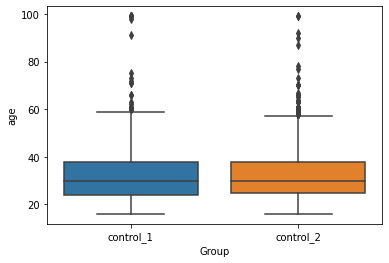

In [12]:
sns.boxplot(data=users_control, x='Group', y='age')

Кажется, что сплитование по возрасту отработало корректно

In [13]:
country_groupped = users_control.groupby(['country', 'Group'], as_index=False) \
    .agg(count=('uid', 'count'))
country_groupped.head()

,country,Group,count
0,Algeria,control_1,2
1,Argentina,control_1,389
2,Argentina,control_2,397
3,Armenia,control_1,1
4,Australia,control_1,50


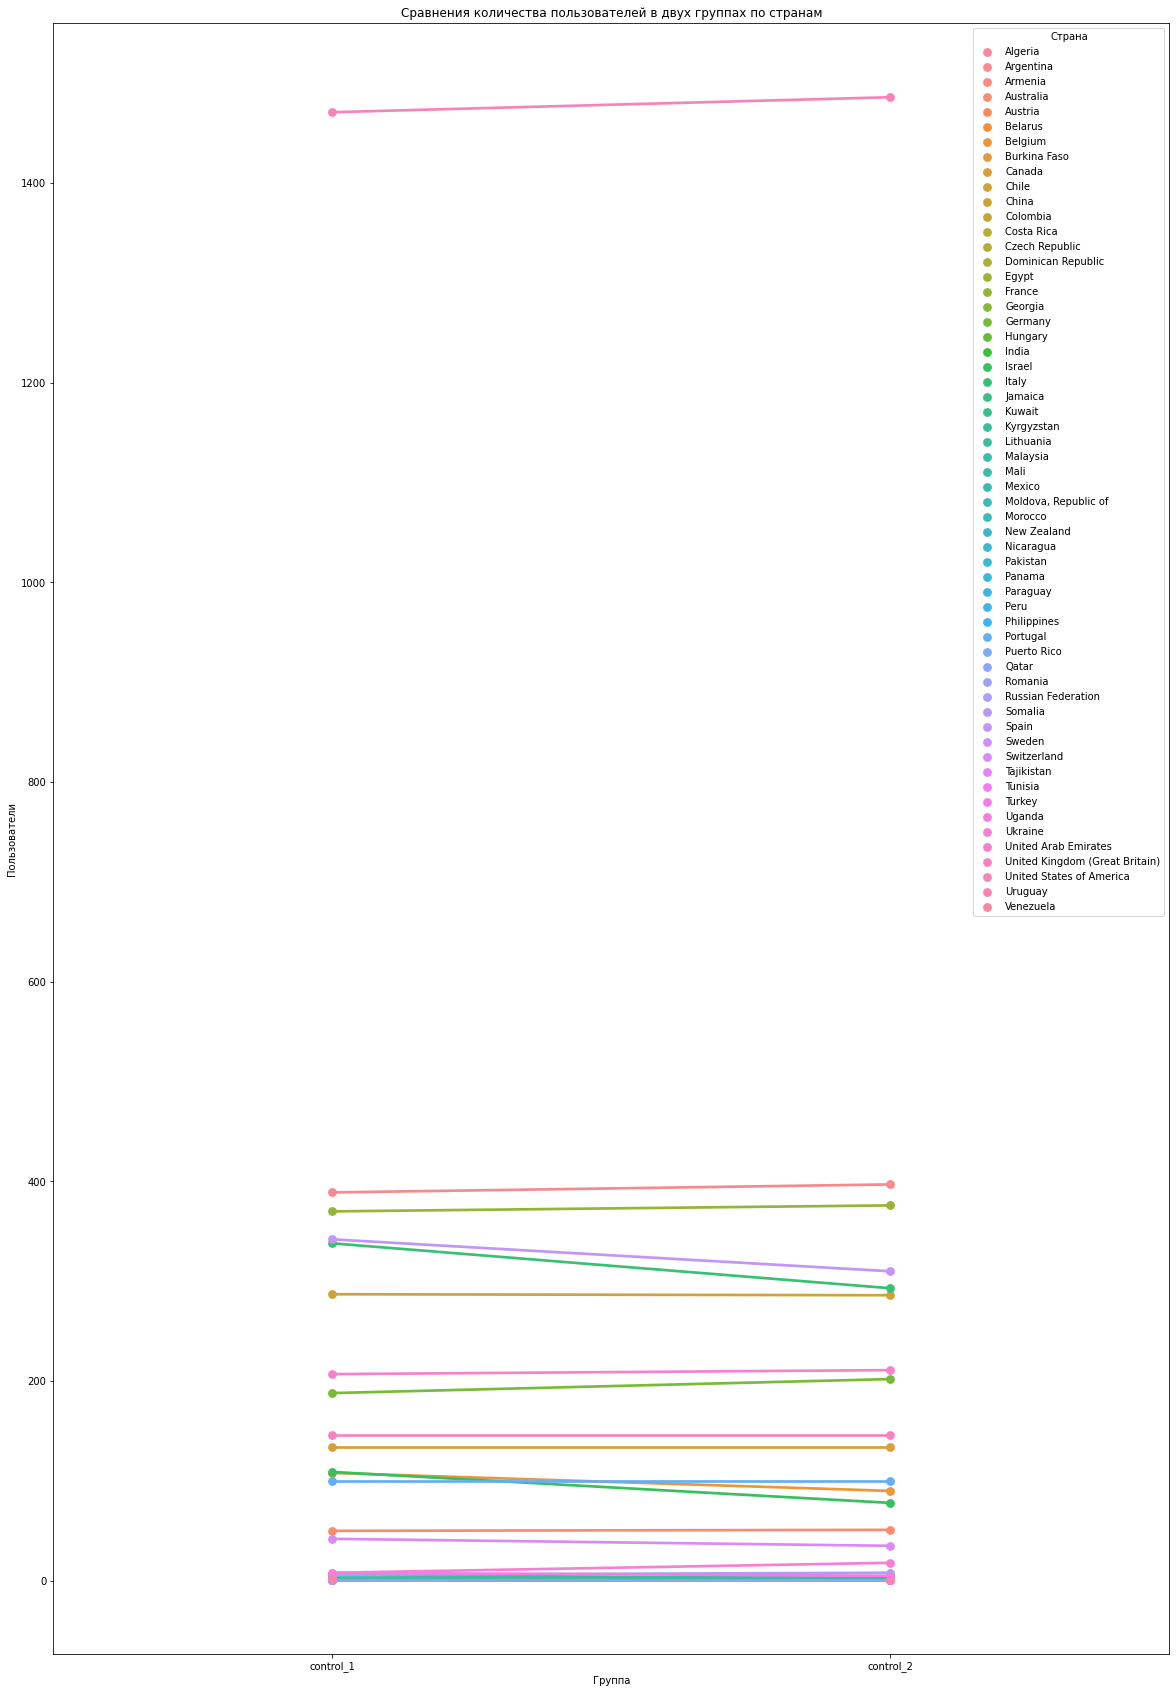

In [14]:
plt.figure(figsize=(20, 30))
sns.pointplot(data=country_groupped, x='Group', y='count', hue='country')
plt.title('Сравнения количества пользователей в двух группах по странам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')
plt.legend(title='Страна')

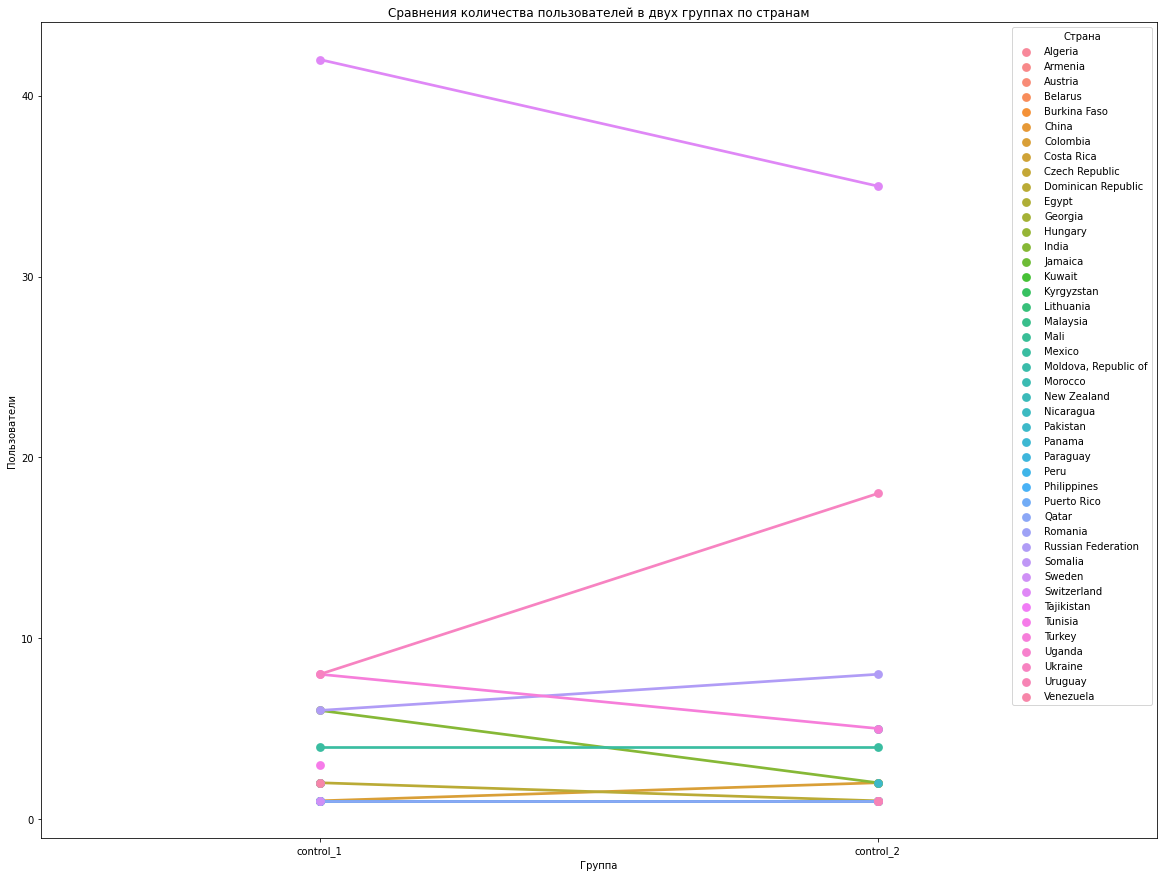

In [15]:
plt.figure(figsize=(20, 15))
sns.pointplot(data=country_groupped.query("count < 50"),
              x='Group', y='count', hue='country')
plt.title('Сравнения количества пользователей в двух группах по странам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')
plt.legend(title='Страна')

Визуально сплитование по странам отработало корректно, однако проверю статистически при помощи таблицы сопряженности. 

In [16]:
country_cross = pd.crosstab(users_control.country, users_control.Group)

In [17]:
res = chi2_contingency(country_cross[['control_1', 'control_2']])
print(
    f"p-value: {res[1]}. В нашем эксперименте распределение групп по странам стат. значимо не различается.")

p-value: 0.27909517540559636. В нашем эксперименте распределение групп по странам стат. значимо не различается.


In [18]:
gender_split = users_control.groupby(['gender', 'Group'], as_index=False) \
                            .agg(count=('uid', 'count'))

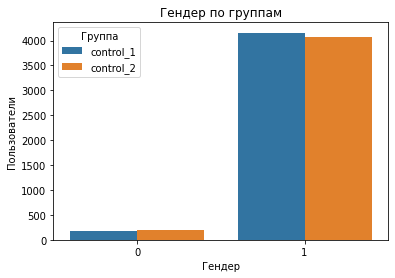

In [19]:
sns.barplot(data=gender_split, x='gender', y='count', hue='Group')
plt.title('Гендер по группам')
plt.ylabel('Пользователи')
plt.xlabel('Гендер')
plt.legend(title='Группа')

Система сплитования по полу тоже разделила примерно одинаково в двух контрольных группах. 

In [20]:
attraction_split = users_control.groupby('Group', as_index=False) \
                                .agg({'attraction_coeff': 'mean'})
attraction_split

,Group,attraction_coeff
0,control_1,312.048848
1,control_2,317.957317


In [21]:
stats.ttest_ind(users_control.query("Group == 'control_1'").attraction_coeff,
                users_control.query("Group == 'control_2'").attraction_coeff)

Ttest_indResult(statistic=-0.8468583815658137, pvalue=0.3970976217112976)

В нашем эксперименте привлекательность пользователей в двух контрольных группах стат. значимо не различается)

Теперь посмотрю на то, как разделили премиум пользователей 

In [22]:
was_prem_split = users_control.groupby('Group', as_index=False) \
                              .agg({'was_premium': 'count'})

is_prem_split = users_control.groupby('Group', as_index=False) \
    .agg({'is_premium': 'count'})

Text(0.5, 0, 'Группа')

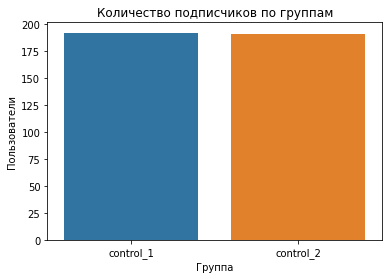

In [23]:
sns.barplot(data=is_prem_split, x='Group', y='is_premium')
plt.title('Количество подписчиков по группам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')

Text(0.5, 0, 'Группа')

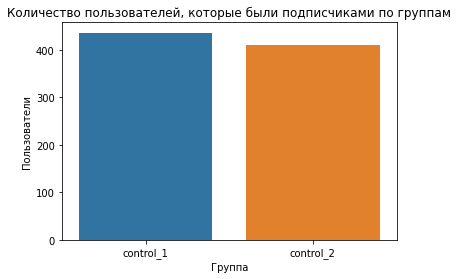

In [24]:
sns.barplot(data=was_prem_split, x='Group', y='was_premium')
plt.title('Количество пользователей, которые были подписчиками по группам')
plt.ylabel('Пользователи')
plt.xlabel('Группа')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Нормаированная выручка')

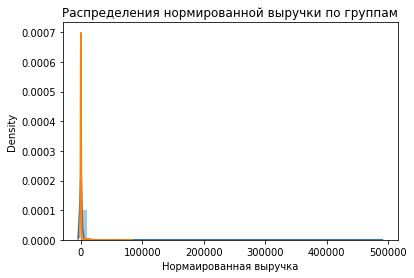

In [25]:
sns.distplot(users_control_1.total_revenue)
sns.distplot(users_control_2.total_revenue)
plt.title('Распределения нормированной выручки по группам')
plt.xlabel('Нормаированная выручка')

Визуально сплитование отработало корректно. 

Теперь перейду к A/A/B тестированию. Буду считать следующие метрики:
    
1. ARRPU
2. Retention
3. Конверсия в подписчика


# A/A/B test

In [26]:
# Для начала подготовлю датафреймы
users_test['Group'] = 'test'
users = pd.concat([users_control, users_test])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Нормаированная выручка')

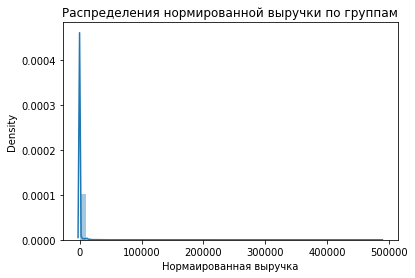

In [27]:
sns.distplot(users.total_revenue)
plt.title('Распределения нормированной выручки по группам')
plt.xlabel('Нормаированная выручка')

Распределение довольно сильно отличается от нормального, поскольку большинство людей пользуются бесплатной версией приложения. Возьму только платящих пользователей и проверю являются ли дисперсии внутри групп гомогенными. 

In [28]:
p_value = stats.levene(users.query("Group == 'test' and total_revenue > 0").total_revenue, users.query(
    "Group == 'control_1' and total_revenue > 0").total_revenue, users.query("Group == 'control_2' and total_revenue > 0").total_revenue)[1]
print(f"p-value: {p_value}. Не отклоняю нулевую гипотезу. Делаю вывод, что в нашем эксперименте дисперсии внутри групп сильно не различаются, поэтому проведу дисперсионый анализ")

p-value: 0.4049689171230868. Не отклоняю нулевую гипотезу. Делаю вывод, что в нашем эксперименте дисперсии внутри групп сильно не различаются, поэтому проведу дисперсионый анализ


In [29]:
stats.f_oneway(users.query("Group == 'test' and total_revenue > 0").total_revenue, users.query(
    "Group == 'control_1' and total_revenue > 0").total_revenue, users.query("Group == 'control_2' and total_revenue > 0").total_revenue)

F_onewayResult(statistic=2.1615645766610014, pvalue=0.11617439545974195)

Дисперсионный анализ не выявил стат.значимых различий между нормированной выручкой в наших группах. Попробую убрать выбросы и сравнить еще раз.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


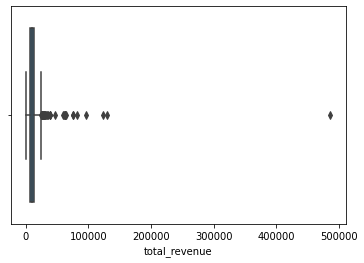

In [30]:
sns.boxplot(users.query("total_revenue > 0").total_revenue)

Есть ярко выраженные выбросы, избавлюсь от них по 99 квантилю, т.к планирую сравнивать средние значения.

In [31]:
quantile = users.total_revenue.quantile(0.99)
users_clean = users.query("total_revenue <= @quantile")

In [32]:
p_value = stats.levene(users_clean.query("Group == 'test' and total_revenue > 0").total_revenue, users_clean.query(
    "Group == 'control_1' and total_revenue > 0").total_revenue, users_clean.query("Group == 'control_2' and total_revenue > 0").total_revenue)[1]
print(f"p-value: {p_value}. Не отклоняю нулевую гипотезу. Делаю вывод, что в нашем эксперименте дисперсии внутри групп не различаются, в таком случае для сравнения испольую дисперсионный анализ и Bootstrap")

p-value: 0.09358429775575502. Не отклоняю нулевую гипотезу. Делаю вывод, что в нашем эксперименте дисперсии внутри групп не различаются, в таком случае для сравнения испольую дисперсионный анализ и Bootstrap


In [33]:
stats.f_oneway(users_clean.query("Group == 'test' and total_revenue > 0").total_revenue, users_clean.query(
    "Group == 'control_1' and total_revenue > 0").total_revenue, users_clean.query("Group == 'control_2' and total_revenue > 0").total_revenue)

F_onewayResult(statistic=4.026506726452781, pvalue=0.018575535814011803)

Если убрать выбросы, то диперсионный анализ показывает стат. значимую разничу в нормированной выручке между, как минимум, двумя группами. Отклоняю H0, проверю между какими группами обнаружено стат. значимое различие при помощи критерия Тьюки.


In [34]:
print(pairwise_tukeyhsd(users_clean.query("total_revenue > 0").total_revenue,
      users_clean.query("total_revenue > 0").Group))

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
control_1 control_2 -289.3083 0.7492 -1275.351  696.7343  False
control_1      test 1040.2601 0.0776  -87.2366 2167.7568  False
control_2      test 1329.5684 0.0158  203.4956 2455.6413   True
---------------------------------------------------------------


Критерий Тьюки показал стат. значимую разниу в revenue среди платящих пользователей между второй контрольной и тестовой группой. 

Теперь сравню две контрольные группы с тестовой при помощи бутстрэпа

In [35]:
# различие в средних значениях между двумя группами
diffs = []

# повторяю процесс 10000 раз
for i in range(10000):

    # симулирую выборку
    sample_data_test = users_clean.query(
        "Group == 'test' and total_revenue > 0").total_revenue.sample(frac=1, replace=True)
    sample_data_control = users_clean.query(
        "Group in ('control_1', 'control_2') and total_revenue > 0").total_revenue.sample(frac=1, replace=True)

    # считаем среднее значение
    sample_mean_test = sample_data_test.mean()
    sample_mean_control = sample_data_control.mean()

    # Добавляю результат в список
    diffs.append(sample_mean_test - sample_mean_control)

lbound = pd.Series(diffs).quantile(0.025)
hbound = pd.Series(diffs).quantile(0.975)

print(
    f"95% значений находятся на промежутке от {lbound} до {hbound}. В доверительый интервал не попал 0, поэтому также отклоняем H0")

95% значений находятся на промежутке от 286.9469296397727 до 2081.1533152517386. В доверительый интервал не попал 0, поэтому также отклоняем H0


In [36]:
# Посмотрю на ARRPU по группам для понимания увеличился он или уменьшился
users_clean.query("total_revenue > 0") \
    .groupby('Group', as_index=False) \
    .agg(ARRPU=('total_revenue', 'mean'))

,Group,ARRPU
0,control_1,7678.867550
1,control_2,7389.559211
2,test,8719.127660


ARRPU стат.  значимо увеличился между второй контрольной и тестовой группой. Теперь сравню по странам, а также по среднему "чеку" по типу продукта.


In [37]:
pg.anova(data=users_clean, dv="total_revenue", between=["Group", "country"])

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 24
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 142, but rank is 111
  'rank is %d' % (J, J_), ValueWarning)


,Source,SS,DF,MS,F,p-unc,np2
0,Group,3.175191e-02,2.0,1.587595e-02,7.087510e-09,1.000000e+00,1.120732e-12
1,country,2.645509e+09,71.0,3.726070e+07,1.663431e+01,1.702918e-68,8.540263e-02
2,Group * country,4.677442e+08,142.0,3.293973e+06,1.470530e+00,9.836697e-04,1.624160e-02
3,Residual,2.833140e+10,12648.0,2.239990e+06,NaN,NaN,NaN


Проведя множественный дисперсионный анализ выяснил, что значим как эффект обоих факторов, так и их взаимодействие.

In [38]:
countries = users.country.unique()

for country in countries:
    # Передаю переменным значения total_revenue
    arrpu_test = users_clean.query(
        "total_revenue > 0 and country == @country and Group == 'test'").total_revenue
    arrpu_control1 = users_clean.query(
        "total_revenue > 0 and country == @country and Group == 'control_1'").total_revenue
    arrpu_control2 = users_clean.query(
        "total_revenue > 0 and country == @country and Group == 'control_2'").total_revenue

    # Если во всех группах есть данные по стране, то провожу дисперсионный анализ
    if len(arrpu_test) > 0 and len(arrpu_control1) > 0 and len(arrpu_control2) > 0:
        p_value = stats.f_oneway(arrpu_test, arrpu_control1, arrpu_control2)[1]

    if p_value <= 0.05:
        # Если между хотя бы двумя группами есть стат. знаимые различия, то вывожу эту страну со значением p-value
        print(f"{country}, p_value: {p_value}\n")
        # И сравниваю группы критерием Тьюки
        print(pairwise_tukeyhsd(users_clean.query("total_revenue > 0 and country == @country").total_revenue,
              users_clean.query("total_revenue > 0 and country == @country").Group))
        print("\n")

United States of America, p_value: 0.020073575661733414

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
control_1 control_2 -1393.0887 0.1068 -3011.5867  225.4094  False
control_1      test   549.6871 0.7234 -1218.3277 2317.7018  False
control_2      test  1942.7758  0.023   218.0296 3667.5219   True
-----------------------------------------------------------------


United Kingdom (Great Britain), p_value: 0.031632943775191484

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
control_1 control_2 -2590.0179 0.1847 -6196.6768 1016.6411  False
control_1      test -4850.3929 0.0286 -9218.2738  -482.512   True
control_2      test  -2260.375 0.3821 -6527.8314 2007.0814  False
--------------------

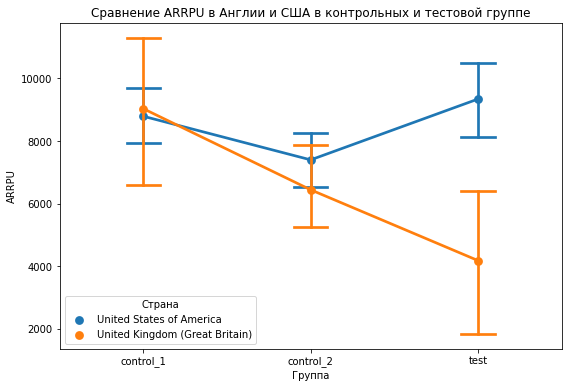

In [58]:
sns.pointplot(x='Group', y='total_revenue', hue='country', data=users_clean.query(
    "total_revenue > 0 and country in ('United States of America', 'United Kingdom (Great Britain)')"), capsize=.2)
plt.title('Сравнение ARRPU в Англии и США в контрольных и тестовой группе')
plt.xlabel('Группа')
plt.ylabel('ARRPU')
plt.legend(title='Страна')

Можно заметить, что в Америке тестовая группа показала рост ARRPU, а в Англии наоборот падение. Теперь перейду к сравнению категорий.



In [59]:
# Объединю данные
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

transactions = pd.concat(
    [transactions_test, transactions_control_1, transactions_control_2])

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'выручка')

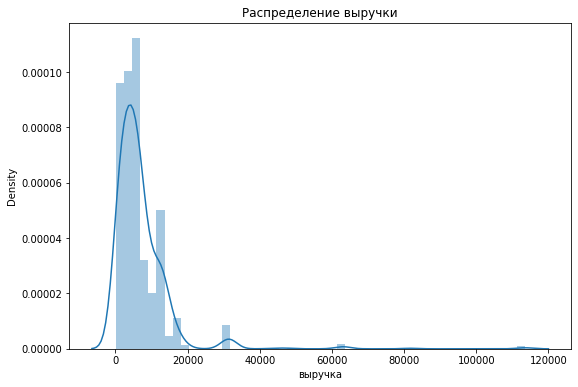

In [60]:
# Проверю распределение
sns.distplot(transactions.revenue)
plt.title('Распределение выручки')
plt.xlabel('выручка')

Распределение  визуально сильно отличается от нормального, однако является довольное типичным для выручки.

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


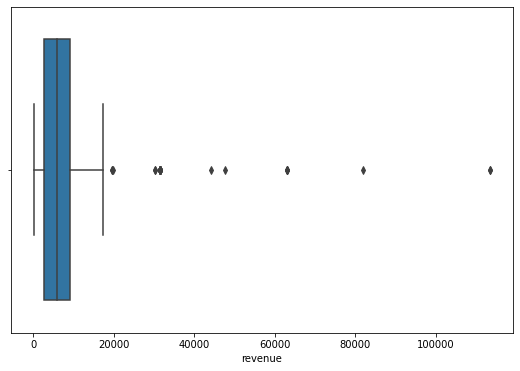

In [61]:
# И выбросы
sns.boxplot(transactions.revenue)

In [62]:
# Удаляю выбросы по 99 квантилю
quantile = transactions.revenue.quantile(0.99)
transactions_clean = transactions.query("revenue <= @quantile")

In [63]:
categories = transactions_clean.product_type.unique()

for category in categories:
    product_type_test = transactions_clean.query(
        "group == 'test' and product_type == @category").revenue
    product_type_control1 = transactions_clean.query(
        "group == 'control_1' and product_type == @category").revenue
    product_type_control2 = transactions_clean.query(
        "group == 'control_2' and product_type == @category").revenue

    # Если во всех группах есть данные по типу продукту, то провожу дисперсионный анализ
    if len(product_type_test) > 0 and len(product_type_control1) > 0 and len(product_type_control2) > 0:
        p_value = stats.f_oneway(
            product_type_test, product_type_control1, product_type_control2)[1]

        if p_value <= 0.05:
            # Если между хотя бы двумя группами есть стат. знаимые различия, то вывожу этот продукт со значением p-value
            print(f"{category}, p_value: {p_value}\n")
            # И сравниваю группы критерием Тьюки
            print(pairwise_tukeyhsd(transactions_clean.query("product_type == @category").revenue,
                  transactions_clean.query("product_type == @category").group))

trial_premium, p_value: 0.006755991640444878

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
control_1 control_2  617.4506 0.3539 -439.2877 1674.1889  False
control_1      test 1373.3495 0.0045  360.3395 2386.3596   True
control_2      test   755.899 0.2233 -319.4942 1831.2922  False
---------------------------------------------------------------
premium_no_trial, p_value: 1.6640397231206864e-14

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj   lower     upper   reject
--------------------------------------------------------------
control_1 control_2   396.165 0.366 -291.6868 1084.0167  False
control_1      test 2570.6484 0.001 1815.1304 3326.1664   True
control_2      test 2174.4834 0.001 1423.5171 2925.4496   True
--------------------------------------------------------------
coins, p_value

Средний "чек" стат.значимо изменился во всех категориях, которые имеют отношения к подписке (за внутреннюю калюту ее также можно купить)

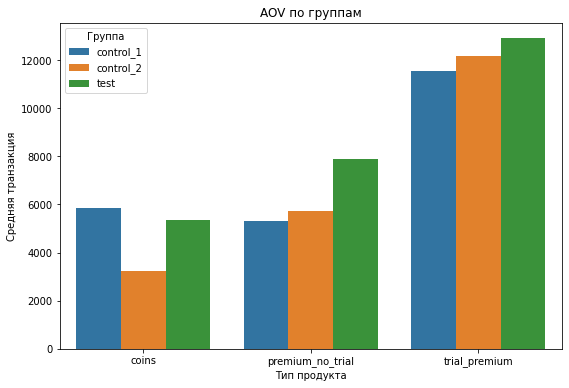

In [64]:
# Посмотрю на AOV по группам для понимания увеличился он или уменьшился
revenue_product = transactions_clean.query("product_type in ('trial_premium', 'premium_no_trial', 'coins')") \
    .groupby(['group', 'product_type'], as_index=False) \
    .agg(AOV=('revenue', 'mean'))
plt.rcParams["figure.figsize"] = (9, 6)
sns.barplot(data=revenue_product, x='product_type', y='AOV', hue='group')

plt.title('AOV по группам')
plt.xlabel('Тип продукта')
plt.ylabel('Средняя транзакция')
plt.legend(title='Группа')

В trial_premium стат. значимо увеличилась средняя транзакци в тестовой группе по сравнению с первой контрольной группой.  В premium_no_trial произошло стат. значимое увеличение в сравнении с двумя контрольными группами. В coins стат. значимое различие между двумя контрольными группами ( возможно, система сплитования отработала не совсем идеально ) и между второй контрольной и тестовой группами. 

Теперь перейду к сравнению retention.

In [65]:
# Распарсю visit_days
# Оставлю только премиум пользователей
retention = users.query("is_premium == 1")

retention['visit_days'] = retention['visit_days'].fillna(0)

retention['visit_days'] = retention['visit_days'].apply(
    lambda x: '[' + str(x) + ']')
retention['visit_days'] = retention['visit_days'].apply(literal_eval)

retention = retention.explode('visit_days')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [66]:
# Буду считать retention 7 дня.
# Проставляю маркер ретеншона

retention['retention'] = np.where(retention['visit_days'] == 7, 1, 0)

In [67]:
retention_seven = retention.groupby(['uid', 'Group', 'is_premium', 'country'], as_index=False) \
                           .agg({'retention': 'sum'}) \
                           .sort_values('retention', ascending=False)

In [68]:
retention_control_1 = round(retention_seven.query(
    "Group == 'control_1'").retention.mean() * 100, 2)
retention_control_2 = round(retention_seven.query(
    "Group == 'control_2'").retention.mean() * 100, 2)
retention_test = round(retention_seven.query(
    "Group == 'test'").retention.mean() * 100, 2)

print(f"""
Retention 7 дня в 1 контрольной группе равен {retention_control_1} %
Retention 7 дня во 2 контрольной группе равен {retention_control_2} %
Retention 7 дня в тестовой группе равен {retention_test} %

Можно отметить, что значения практически не различаются. Однако, надо проверить статистически. 
        """
      )


Retention 7 дня в 1 контрольной группе равен 36.24 %
Retention 7 дня во 2 контрольной группе равен 39.17 %
Retention 7 дня в тестовой группе равен 37.75 %

Можно отметить, что значения практически не различаются. Однако, надо проверить статистически. 
        


In [69]:
ztest(retention_seven.query("Group in ('control_1', 'control_2')").retention,
      retention_seven.query("Group == 'test'").retention, value=0)

(-0.028316265385808916, 0.9774099078996915)

Использовав z-test для сравнения A1 + A2 / B, прихожу к выводу, что у нас нет достаточных доказательств, чтобы сказать, что retention различается между двумя выборками. Проверю также через Хи-квадрат.


In [70]:
retention = [retention_control_1, retention_control_2, retention_test]
stats.chisquare(f_obs=retention)

Power_divergenceResult(statistic=0.11383351007423115, pvalue=0.9446727053377475)

Retention стат. значимо не отличается в группах. сравню по странам. 

In [71]:
countries = users.country.unique()

for country in countries:
    retention_control_1 = retention_seven.query(
        "Group == 'control_1' and country == @country").retention.mean()
    retention_control_2 = retention_seven.query(
        "Group == 'control_2' and country == @country").retention.mean()
    retention_test = retention_seven.query(
        "Group == 'test' and country == @country").retention.mean()

    retention = [retention_control_1, retention_control_2, retention_test]
    chisquare_pvalue = stats.chisquare(f_obs=retention)[1]

    if chisquare_pvalue <= 0.05:
        print(country, retention)

Ни в одной из стран не отклоняем H0, которая говорит, что переменные не связаны друг с другом. Теперь перейду к расчету конверсии в подписчика

In [72]:
users['was_premium'] = users['was_premium'].fillna(0)
users['is_premium'] = users['was_premium'].fillna(0)

In [73]:
# Для начала беру количество уникальных пользователей по группам
# У каждой строчки уникальный пользователь, дубликатов нет
users_control1 = users.query("Group == 'control_1'").uid.nunique()
users_control2 = users.query("Group == 'control_2'").uid.nunique()
users_test = users.query("Group == 'test'").uid.nunique()

# Беру количество платных подписчиков.
# Пользователей, которые когда-то были подписчиками тоже буду считать сконевртированными 
prems_control1 = users.query(
    "Group == 'control_1' and (is_premium == 1 or was_premium ==1)").shape[0]
prems_control2 = users.query(
    "Group == 'control_2' and (is_premium == 1 or was_premium == 1)").shape[0]
prems_test = users.query(
    "Group == 'test' and (is_premium == 1 or was_premium == 1)").shape[0]

# Считаю конверсию в подписчика
cr_control1 = prems_control1 / users_control1
cr_control2 = prems_control2 / users_control2
cr_test = prems_test / users_test

conversion = pd.DataFrame(
    {'control_1': cr_control1, 'control_2': cr_control2, 'test': cr_test}, index=[0])
conversion

,control_1,control_2,test
0,0.100461,0.096388,0.094708


In [74]:
conversion = [cr_control1, cr_control2, cr_test]

In [75]:
stats.chisquare(f_obs=conversion)

Power_divergenceResult(statistic=0.00018010475324955604, pvalue=0.9999099516779688)

In [76]:
countries = users.country.unique()

for country in countries:

    control1 = users.query("Group == 'control_1' and country == @country")
    control2 = users.query("Group == 'control_2' and country == @country")
    test = users.query("Group == 'test' and country == @country")

    if len(control1) > 0 and len(control2) > 0 and len(test) > 0:
        # Для начала беру количество уникальных пользователей по группам
        # У каждой строчки уникальный пользователь, дубликатов нет
        users_control1 = control1.uid.nunique()
        users_control2 = control2.uid.nunique()
        users_test = test.uid.nunique()

        # Беру количество платных подписчиков.
        # Пользователей, которые когда-то были подписчиками тоже буду считать сконевртированными 
        prems_control1 = users.query(
            "Group == 'control_1' and (is_premium == 1 or was_premium ==1) and country == @country").shape[0]
        prems_control2 = users.query(
            "Group == 'control_2' and (is_premium == 1 or was_premium == 1) and country == @country").shape[0]
        prems_test = users.query(
            "Group == 'test' and (is_premium == 1 or was_premium == 1) and country == @country").shape[0]
        if prems_control1 > 0 and prems_control2 > 0 and prems_test > 0:
            # Считаю конверсию в подписчика
            cr_control1 = prems_control1 / users_control1
            cr_control2 = prems_control2 / users_control2
            cr_test = prems_test / users_test

            conversion = [cr_control1, cr_control2, cr_test]

            p_value = stats.chisquare(f_obs=conversion)[1]

            if p_value <= 0.05:
                print(country, conversion)

У конверсии в подписчика результат схож с retention. Ни в одной из стран не отклоняем H0, которая говорит, что переменные не связаны друг с другом. 
Перехожу к выводу

# Вывод

В датафрейм первой контрольной группы попало больше половины Null значений, крайне похоже на ошибку. Также проведя А/А тест была обнаружна стат. значима разница в средней транзакции внутренней валюты. 

Поскольку A/A/B был проведен не мной, я не могу знать ключевую метрику, которую хотели отслеживать, следовательно  не смогу достоверно оценить его результат. Однако я проанализировал 3 метрики:

1. ARRPU;
2. retention;
3. конверсия в премиум подписчика.

Пришел к следующим выводам:

Нормированная выручка стат. значимо увеличилась в тестовой группе ( по сравнению со второй контрольной, при удалении выбросов ). В Америке тестовая группа показала рост ARRPU, а в Англии наоборот падение. 

Сравнивая среднюю транзакцию по типам продукта, пришел к выводу, что в trial_premium стат. значимо увеличилась средняя транзакци в тестовой группе по сравнению с первой контрольной.  В premium_no_trial произошло стат. значимое увеличение в сравнении с двумя контрольными группами. В coins стат. значимое различие между двумя контрольными группами  и между второй контрольной и тестовой группами. 

Стат. значимых различий в конверсии и удержании (7 дня) мною обнаружено не было. 

В работе были использованы следующие статистические тесты:

1. Дисперсионный анализ;
2. множественный дисперсионный анализ;
3. критерий Тьюки;
4. z-test;
5. хи-квадрат;
6. таблицы сопряженности.
